In [ ]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable #для создания дополнительной оси для цветовой шкалы

In [171]:
connection = sqlite3.connect('../data/checking-logs.sqlite')

In [172]:
query = """
SELECT 
    uid as user_id,
    CAST(strftime('%w', timestamp) AS INT) as weekday,
    CAST(strftime('%H', timestamp) AS INT) as hour,
    COUNT(*) as commits
FROM checker
WHERE uid LIKE 'user%'
GROUP BY user_id, weekday, hour
ORDER BY user_id, weekday, hour
"""

In [173]:
df = pd.read_sql(query, connection)
df

,user_id,weekday,hour,commits
0,user_0,1,17,3
1,user_1,0,16,1
2,user_1,0,17,8
3,user_1,0,19,12
4,user_1,0,20,22
...,...,...,...,...
512,user_8,6,15,14
513,user_8,6,16,8
514,user_8,6,17,3
515,user_8,6,20,1


## Преобразование дней недели (Чтобы Вс был в конце)

In [174]:
df['weekday'] = df['weekday'].replace(0, 7)
weekday_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

## Подготовка данных для визуализации

### 1. По дням недели

In [175]:
weekday_pivot = df.pivot_table(
    index='user_id',
    columns='weekday',
    values='commits',
    aggfunc='sum',
    fill_value=0
)

### Сортировка пользователей по общему количеству коммитов

In [176]:
weekday_pivot = weekday_pivot.loc[weekday_pivot.sum(axis=1).sort_values(ascending=False).index]

### Переименование столбцов и транспонирование для визуализации

In [177]:
weekday_pivot.columns = weekday_names
weekday_pivot = weekday_pivot.T

## 2. По часам суток

In [178]:
hour_pivot = df.pivot_table(
    index='user_id',
    columns='hour',
    values='commits',
    aggfunc='sum',
    fill_value=0
)

### Сортировка по пользователям и часам, транспонирование

In [179]:
hour_pivot = hour_pivot.loc[weekday_pivot.columns].sort_index(axis=1)
hour_pivot = hour_pivot.T

## 3. Визуализация

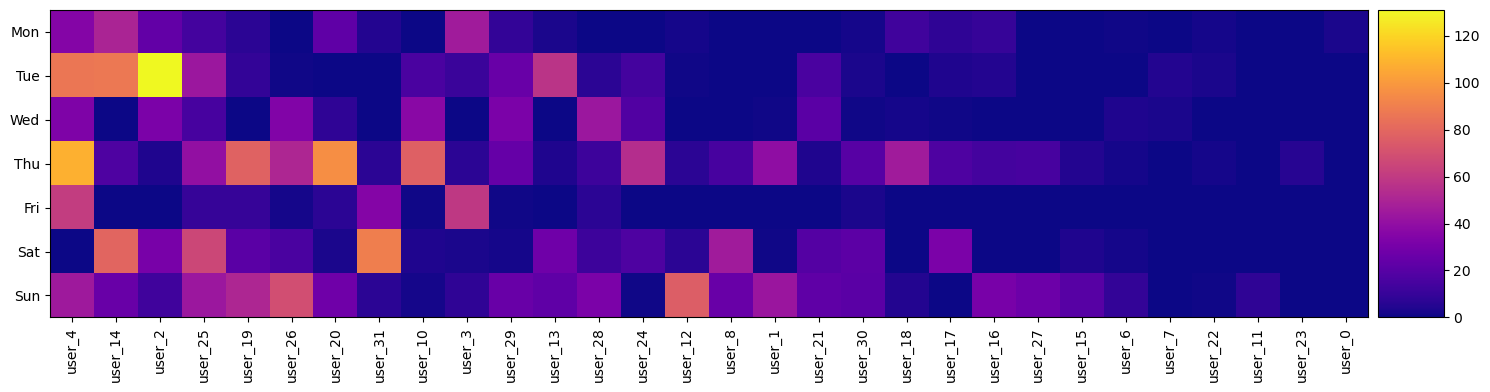

In [180]:
# 1. По дням недели
fig, ax = plt.subplots(figsize=(15, 5))
im = ax.imshow(weekday_pivot, cmap='plasma')
ax.set_xticks(range(len(weekday_pivot.columns)))
ax.set_xticklabels(weekday_pivot.columns, rotation=90)
ax.set_yticks(range(len(weekday_pivot.index)))
ax.set_yticklabels(weekday_pivot.index)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(im, cax=cax)
plt.tight_layout()
plt.show()

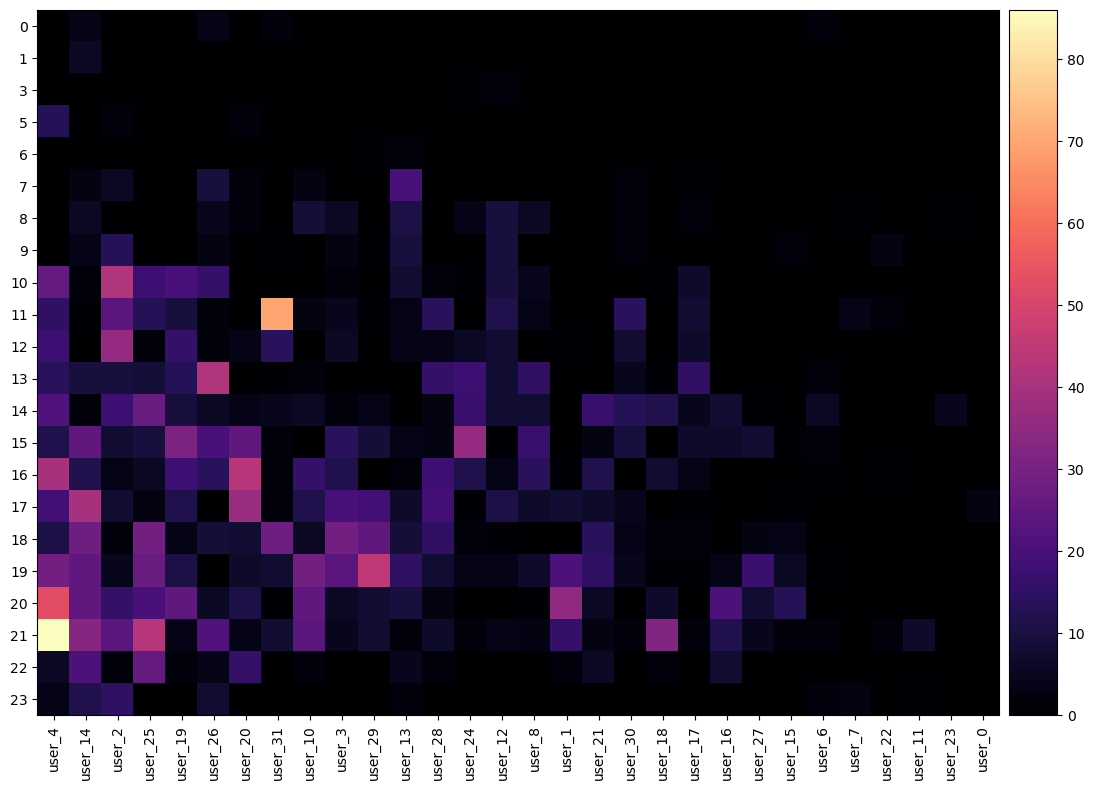

In [181]:
# 2. По часам суток
fig, ax = plt.subplots(figsize=(15, 8))
im = ax.imshow(hour_pivot, cmap='magma')
ax.set_xticks(range(len(hour_pivot.columns)))
ax.set_xticklabels(hour_pivot.columns, rotation=90)
ax.set_yticks(range(len(hour_pivot.index)))
ax.set_yticklabels(hour_pivot.index)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(im, cax=cax)
plt.tight_layout()
plt.show()

## Какой пользователь имеет больше всего коммитов во вторник?

### Ответ: user_2

## Какой пользователь имеет больше всего коммитов в Чт?

### Ответ: user_4

## В какой день недели пользователи не любят делать много коммитов?

###  Ответ: Пт

## Какой пользователь в какой час сделал наибольшее количество коммитов?

### Ответ: user_4, 21

In [182]:
connection.close()